<a href="https://colab.research.google.com/github/carlibeisel/irrigation_efficiency_change/blob/main/pivot_irrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Identifying Pivot Irrigated Land

By: Carli Beisel

Adapted from David Ketchum (Github: dgketchum)

Created on May 13, 2024

Modified on  May 17, 2024

----------------------------------------------------
**Purpose:**

1) Finds pivot irrigated areas in irrigation shapefile. This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot". This Script is directly from David Ketchum.

2) Sums area of pivot irrigation for each shapefile and combines into one dataframe. The created dataframe that has two columns: year and total acres of pivot irrigation.

3) Generates a regression plot of irrigation change over time with the genderated dataframe.

## 1. Finds pivot irrigated areas in irrigation shapefile. This code assumes that circles/arcs in the landscape represent pivot irrigation. This script finds arcs in polygon geometries of the shapefile, and writes a new attribute called "pivot".

This script is directly from David Ketchum.


In [4]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
! pip install pandarallel
from pandarallel import pandarallel

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.4 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=45fdb6ee807fdc68e09c898b6e7f0aaff947bd19522c2634fa3127753b6e0fd4
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
min_arc = 10
tol = 0.22

In [8]:
def area_flood_irrigation(shp):
    df = gpd.read_file(shp)
    p = df[df['IType'] == 'P']['geometry']
    p = np.sum([g.area for g in p])
    s = df[df['IType'] == 'S']['geometry']
    s = np.sum([g.area for g in s])
    f = df[df['IType'] == 'F']['geometry']
    f = np.sum([g.area for g in f])
    t = p + s + f
    print('pivot: {:.3f} sqkm, {:.3f}'.format(p / 1e6, p / t))
    print('sprinkler: {:.3f} sqkm, {:.3f}'.format(s / 1e6, s / t))
    print('flood: {:.3f} sqkm, {:.3f}'.format(f / 1e6, f / t))

In [9]:
# Calculates the bearing between two points given their coordinates.
def bearing(a, b):
    lat1 = np.radians(a[0])
    lat2 = np.radians(b[0])

    diffLong = np.radians(b[1] - a[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
                                       * np.cos(lat2) * np.cos(diffLong))

    return np.arctan2(x, y)

In [10]:
# Identify arcs within a geometry by checking the bearing between consecutive
# vertices. If the bearing difference falls below a certain tolerance for a
# specified number of consecutive vertices (min_arc), it returns True,
# indicating the presence of an arc.

def find_arcs(g):
    verts = g.exterior.coords
    arc_ct, b_prev = 0, np.pi
    for i, v in enumerate(verts):
        try:
            next = verts[i + 1]
        except IndexError:
            break
        b = bearing(v, next)
        diff = b - b_prev
        if diff < tol:
            arc_ct += 1
            if arc_ct >= min_arc:
                return True
        else:
            arc_ct = 0
        b_prev = b

    return False

In [13]:
# Identify arcs within geometries in a shapefile. It utilizes the find_arcs
# function and parallel processing using the Pandarallel library.

def pivot_test(in_shp, out_shp):
    pandarallel.initialize(use_memory_fs=False, progress_bar=True)

    df = gpd.read_file(in_shp).explode()
    df.index = range(df.shape[0])
    print('{} features'.format(df.shape[0]))
    df['arc'] = df.geometry.apply(lambda g: find_arcs(g))
    df['arc'] = df.geometry.parallel_apply(find_arcs)
    df.to_file(out_shp, crs='epsg:4326')
    print('{} of {} features have an arc'.format(np.count_nonzero(df['arc']), df.shape[0]))

In [17]:
if __name__ == '__main__':
    in_shp = '/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/2010_irrigated.shp'
    out_shp = '/content/drive/MyDrive/Data/irrigation_shapefiles/pivot/2010_arcs.shp'
    pivot_test(in_shp, out_shp)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


<ipython-input-16-609e694fa8c4>:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = gpd.read_file(in_shp).explode()


35747 features


3865 of 35747 features have an arc


## 2. Sums area of pivot irrigated land and total irrigated land for each shapefile and combines into one dataframe. The created dataframe that has three columns: 1) year, 2) total pivot irrigated acres, and 3) total acres irrigated.

In [1]:
#import libraries
!pip install geopandas shapely
import geopandas as gpd
import glob
import pandas as pd
import re
from shapely.geometry import MultiPolygon #for shapefiles with holes or difficult shapes

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Load the total irrigated land shapefiles
irrigated_fields = '/content/drive/MyDrive/Data/irrigation_shapefiles/irrigated_land_only/*.shp'
shapefiles = glob.glob(irrigated_fields)

# Define a function to extract the year from the filename
def extract_year(filename):
    match = re.search(r'(\d{4})', filename)
    return int(match.group(1)) if match else None

# Iterate over each shapefile and read the "Acres" column
irrigated_acres = []
for shp in shapefiles:
    year = extract_year(shp)
    if year is None:
        continue

    gdf = gpd.read_file(shp)
    total_area_acres = gdf['Acres'].sum()
    irrigated_acres.append({'Year': year, 'Total Irrigated Acres': total_area_acres})

# Create and sort the DataFrame by Year
all = pd.DataFrame(irrigated_acres).sort_values(by='Year').reset_index(drop=True)

print(all)

   Year  Total Irrigated Acres
0  1987          540858.321895
1  1994          522431.344118
2  2000          543269.737946
3  2004          529101.803133
4  2007          529273.357644
5  2010          527579.091135
6  2015          547752.179370


In [19]:
# Load the pivot irrigation shapefiles
pivot_files = '/content/drive/MyDrive/Data/irrigation_shapefiles/pivot/*.shp'
shapefiles = glob.glob(pivot_files)

# Define a function to extract the year from the filename
def extract_year(filename):
    match = re.search(r'(\d{4})', filename)
    return int(match.group(1)) if match else None

# Iterate over each shapefile and read the "Acres" column
pivot_acres = []
for shp in shapefiles:
    year = extract_year(shp)
    if year is None:
        continue

    gdf = gpd.read_file(shp)
    total_area_acres = gdf['Acres'].sum()
    pivot_acres.append({'Year': year, 'Pivot Acres': total_area_acres})

# Create and sort the DataFrame by Year
pivot = pd.DataFrame(pivot_acres).sort_values(by='Year').reset_index(drop=True)

print(pivot)

   Year    Pivot Acres
0  1987  542038.132894
1  1994  522468.959655
2  2000  543309.197017
3  2004  529166.048913
4  2007  529346.985923
5  2010  542431.941892
6  2015  564898.317981


In [ ]:
#merge pivot and all irrigation style dataframes
merged_data = pd.merge(all, pivot, on='Year', how='inner')
print(merged_data)
merged_data.to_csv('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigation_change.csv', index=False)

   Year  Total Irrigated Acres    Pivot Acres
0  1987          540858.321895  542038.132894
1  1994          522431.344118  522468.959655
2  2000          543269.737946  543309.197017
3  2004          529101.803133  529166.048913
4  2007          529273.357644  529346.985923
5  2010          527579.091135  542431.941892
6  2015          547752.179370  564898.317981


## 3. Generates a regression plot of irrigation change over time with the genderated dataframe.

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/irrigation_shapefiles/irrigation_change.csv')

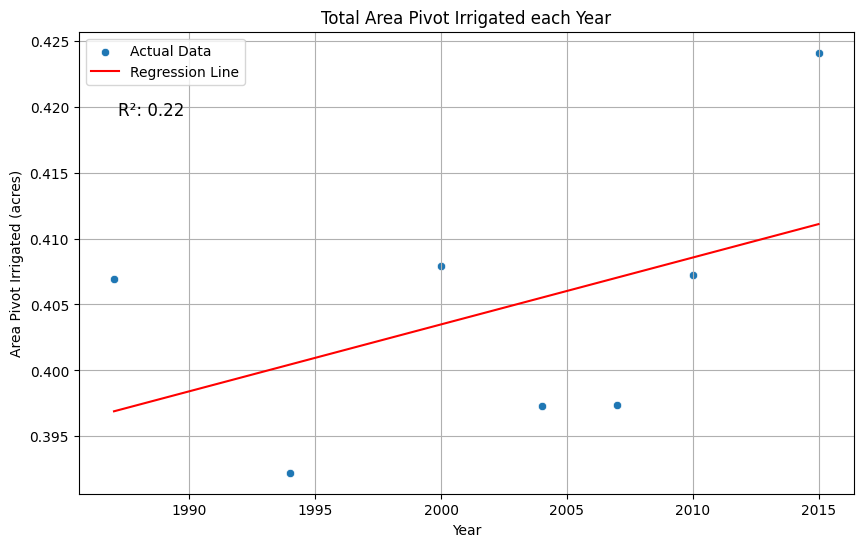

In [ ]:
# Initialize and fit the linear regression model
model = LinearRegression()
X = df[['Year']]
y = df['Proportion_Pivot']
model.fit(X, y)

# Predict values using the fitted model
df['Predicted_Acres'] = model.predict(X)

# Calculate the R² value
r_squared = model.score(X, y)

# Plot scatter plot and regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Year', y='Proportion_Pivot', marker='o', label='Actual Data')
plt.plot(df['Year'], df['Predicted_Acres'], color='red', label='Regression Line')

# Customize the plot
plt.title('Total Area Pivot Irrigated each Year')
plt.xlabel('Year')
plt.ylabel('Area Pivot Irrigated (acres)')
plt.grid(True)
plt.legend()

# Annotate the R² value on the plot
plt.text(
    0.05, 0.85, f'R²: {r_squared:.2f}',
    transform=plt.gca().transAxes, fontsize=12, verticalalignment='top'
)

# Show the plot
plt.show()

In [ ]:
# Calculate proportion of pivot irrigated acres divided by total irrigated acres
df['Proportion_Pivot'] = df['Pivot Acres'] / df['Total Irrigated Acres'] #old version
print(df)

   Year  Total Irrigated Acres    Pivot Acres  Proportion_Pivot
0  1987          540858.321895  542038.132894          0.406932
1  1994          522431.344118  522468.959655          0.392240
2  2000          543269.737946  543309.197017          0.407886
3  2004          529101.803133  529166.048913          0.397268
4  2007          529273.357644  529346.985923          0.397404
5  2010          527579.091135  542431.941892          0.407228
6  2015          547752.179370  564898.317981          0.424094


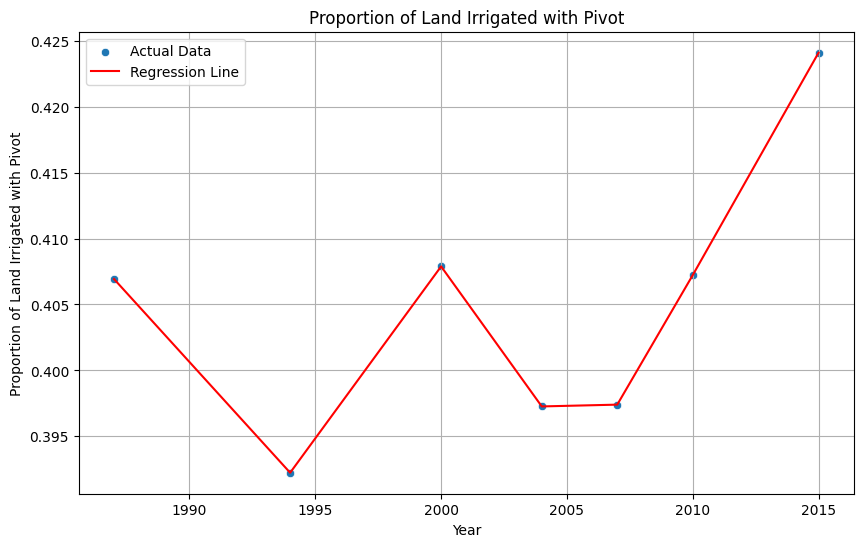

In [ ]:
# Line graph with pivot proportion
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Year', y='Proportion_Pivot', marker='o', label='Actual Data')
plt.plot(df['Year'], df['Proportion_Pivot'], color='red', label='Regression Line')

#Customize the legend
plt.title('Proportion of Land Irrigated with Pivot')
plt.xlabel('Year')
plt.ylabel('Proportion of Land Irrigated with Pivot')
plt.grid(True)
plt.legend()